In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import matplotlib  as mpl
import h5py
import matplotlib.colors as colors
from tqdm import tqdm
from scipy import stats
import cmasher as cmr
import seaborn as sns
import warnings
import multiprocessing as mp
from functools import partial
from tqdm import tqdm
from matplotlib.colors import LogNorm
import os

## Test projection

In [2]:
snapnum = [99,50,33,25,21,17,13]
basePath = "/virgotng/universe/IllustrisTNG/TNG50-1/output"

# Define empty dictionaries to store variables
Galaxie_mass = {num: [] for num in snapnum}
Mass_selec = {num: [] for num in snapnum}
eigenvectors_dict = {num: [] for num in snapnum}
Vmax_dict = {num: [] for num in snapnum}
Vmax_comp_dict = {num: [] for num in snapnum}
Vdisp_dict = {num: [] for num in snapnum}
dataset_number = {num: [] for num in snapnum}

specific_subkey = "eigenvectors"  # Subkey for eigenvectors

# Loop over snapnum values
for num in tqdm(snapnum):

    file_path = f'/virgotng/universe/IllustrisTNG/TNG50-1/output/snapdir_{num:03d}/snap_{num:03d}.0.hdf5'
    
    with h5py.File(file_path, 'r') as f:
        header = dict( f['Header'].attrs.items())
        
    Redshift = header['Redshift']
    hubble_param = header['HubbleParam']

    subgroups = il.groupcat.loadSubhalos(basePath,num,fields="SubhaloMassInHalfRadType")

    Galaxie_mass[num] = np.array(np.log10(subgroups[:,4] * 1e10 / hubble_param))

    # Construct the file path with the current snapnum
    path = f'/vera/u/flolac/Catalogs_kine_proj/New_result_stars_with_kinematics{num}.h5'
    absolute_file_path = os.path.abspath(path)

    with h5py.File(absolute_file_path, 'r') as f:
        # Iterate over the keys (datasets) in the HDF5 file
        for key in f.keys():
            dataset_number[num].append(int(key.split("_")[-1]))
            # If the dataset is a dataset group
            if isinstance(f[key], h5py.Group):
                # Check if the specific subkey exists in this group
                if specific_subkey in f[key].keys():
                    # Retrieve the eigenvectors data
                    eigenvectors = f[key]["eigenvectors"][:]
                    Vmax = f[key]["max_rot_vel"][()]
                    Vmax_comp = f[key]["max_rot_vel_comp"][()]
                    Vdisp = f[key]["V_disp"][()]

                    # Append data to respective lists in dictionaries
                    eigenvectors_dict[num].append(eigenvectors)
                    Vmax_dict[num].append(Vmax)
                    Vmax_comp_dict[num].append(Vmax_comp)
                    Vdisp_dict[num].append(Vdisp)

  0%|                                                                            | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_56927/223658435.py:28: RuntimeWarning: divide by zero encountered in log10
  Galaxie_mass[num] = np.array(np.log10(subgroups[:,4] * 1e10 / hubble_param))
100%|████████████████████████████████████████████████████████████████████| 7/7 [05:29<00:00, 47.13s/it]


In [3]:
"""
snapnum = 33
file_path = f'/virgotng/universe/IllustrisTNG/TNG50-1/output/snapdir_{snapnum:03d}/snap_{snapnum:03d}.0.hdf5'

with h5py.File(file_path, 'r') as f:
    header = dict( f['Header'].attrs.items())
    
Redshift = header['Redshift']
hubble_param = header['HubbleParam']
scaling_factor = 1.0 / (1+Redshift)

basePath = "/virgotng/universe/IllustrisTNG/TNG50-1/output"
fields = ["SubhaloMassType",'SubhaloPos',"SubhaloFlag","SubhaloHalfmassRadType","SubhaloVel"]
subgroups = il.groupcat.loadSubhalos(basePath,snapnum,fields=fields)

stellar_mass =  (subgroups["SubhaloMassType"][:,4] * 1e10 / hubble_param)
#gas_mass =  (subgroups["SubhaloMassType"][:,0] * 1e10 / hubble_param)

Half_mass_rad = subgroups["SubhaloHalfmassRadType"][:,4] * scaling_factor / hubble_param
positions = subgroups["SubhaloPos"]
subhalovel = subgroups["SubhaloVel"]

SubhaloID = np.arange(len(subgroups["SubhaloFlag"]))

Flag_1 = subgroups["SubhaloFlag"] == 1
Flag_2 = stellar_mass > 10**8
#Flag_2 = gas_mass > 10**8
Flag_3 = Half_mass_rad > 0

GalID = SubhaloID[(Flag_1) & (Flag_2)&(Flag_3)]

Compare_ID = dataset_number[33]
common_elements = np.intersect1d(Compare_ID, GalID)

# Print the result
print(common_elements)
"""

'\nsnapnum = 33\nfile_path = f\'/virgotng/universe/IllustrisTNG/TNG50-1/output/snapdir_{snapnum:03d}/snap_{snapnum:03d}.0.hdf5\'\n\nwith h5py.File(file_path, \'r\') as f:\n    header = dict( f[\'Header\'].attrs.items())\n    \nRedshift = header[\'Redshift\']\nhubble_param = header[\'HubbleParam\']\nscaling_factor = 1.0 / (1+Redshift)\n\nbasePath = "/virgotng/universe/IllustrisTNG/TNG50-1/output"\nfields = ["SubhaloMassType",\'SubhaloPos\',"SubhaloFlag","SubhaloHalfmassRadType","SubhaloVel"]\nsubgroups = il.groupcat.loadSubhalos(basePath,snapnum,fields=fields)\n\nstellar_mass =  (subgroups["SubhaloMassType"][:,4] * 1e10 / hubble_param)\n#gas_mass =  (subgroups["SubhaloMassType"][:,0] * 1e10 / hubble_param)\n\nHalf_mass_rad = subgroups["SubhaloHalfmassRadType"][:,4] * scaling_factor / hubble_param\npositions = subgroups["SubhaloPos"]\nsubhalovel = subgroups["SubhaloVel"]\n\nSubhaloID = np.arange(len(subgroups["SubhaloFlag"]))\n\nFlag_1 = subgroups["SubhaloFlag"] == 1\nFlag_2 = stellar_ma

In [64]:
snapnum = [99,50,33,25,21,17,13]

for num in snapnum : 
    Mass = Galaxie_mass[num]
    Mass_selec[num] = np.array([Mass[idx] for idx in dataset_number[num]])

In [65]:
Bin_edges = [9,9.5,10,10.5,11]

In [66]:
mean_rot_bin_1 = []
mean_rot_bin_2 = []
mean_rot_bin_3 = []
mean_rot_bin_4 = []

mean_comp_rot_bin_1 = []
mean_comp_rot_bin_2 = []
mean_comp_rot_bin_3 = []
mean_comp_rot_bin_4 = []

mean_velocity_bin1 = []
mean_velocity_bin2 = []
mean_velocity_bin3 = []
mean_velocity_bin4 = []

std_rot_bin_1 = []
std_rot_bin_2 = []
std_rot_bin_3 = []
std_rot_bin_4 = []

std_comp_rot_bin_1 = []
std_comp_rot_bin_2 = []
std_comp_rot_bin_3 = []
std_comp_rot_bin_4 = []

std_velocity_bin1 = []
std_velocity_bin2 = []
std_velocity_bin3 = []
std_velocity_bin4 = []

In [67]:
for num in snapnum : 
    
    Bin1 = (9 <= Mass_selec[num]) & (Mass_selec[num] < 9.5)
    Bin2 = (9.5 <= Mass_selec[num]) & (Mass_selec[num] < 10)
    Bin3 = (10 <= Mass_selec[num]) & (Mass_selec[num] < 10.5)
    Bin4 = (10.5 <= Mass_selec[num]) & (Mass_selec[num] < 11)
    
    mean_rot_bin_1.append(np.nanmean(np.array(Vmax_dict[num])[Bin1]))
    mean_rot_bin_2.append(np.nanmean(np.array(Vmax_dict[num])[Bin2]))
    mean_rot_bin_3.append(np.nanmean(np.array(Vmax_dict[num])[Bin3]))
    mean_rot_bin_4.append(np.nanmean(np.array(Vmax_dict[num])[Bin4]))

    mean_comp_rot_bin_1.append(np.nanmean(np.array(Vmax_comp_dict[num])[Bin1]))
    mean_comp_rot_bin_2.append(np.nanmean(np.array(Vmax_comp_dict[num])[Bin2]))
    mean_comp_rot_bin_3.append(np.nanmean(np.array(Vmax_comp_dict[num])[Bin3]))
    mean_comp_rot_bin_4.append(np.nanmean(np.array(Vmax_comp_dict[num])[Bin4]))

    mean_velocity_bin1.append(np.nanmean(np.array(Vdisp_dict[num])[Bin1]))
    mean_velocity_bin2.append(np.nanmean(np.array(Vdisp_dict[num])[Bin2]))
    mean_velocity_bin3.append(np.nanmean(np.array(Vdisp_dict[num])[Bin3]))
    mean_velocity_bin4.append(np.nanmean(np.array(Vdisp_dict[num])[Bin4]))

    std_rot_bin_1.append(np.nanstd(np.array(Vmax_dict[num])[Bin1]))
    std_rot_bin_2.append(np.nanstd(np.array(Vmax_dict[num])[Bin2]))
    std_rot_bin_3.append(np.nanstd(np.array(Vmax_dict[num])[Bin3]))
    std_rot_bin_4.append(np.nanstd(np.array(Vmax_dict[num])[Bin4]))

    std_comp_rot_bin_1.append(np.nanstd(np.array(Vmax_comp_dict[num])[Bin1]))
    std_comp_rot_bin_2.append(np.nanstd(np.array(Vmax_comp_dict[num])[Bin2]))
    std_comp_rot_bin_3.append(np.nanstd(np.array(Vmax_comp_dict[num])[Bin3]))
    std_comp_rot_bin_4.append(np.nanstd(np.array(Vmax_comp_dict[num])[Bin4]))

    std_velocity_bin1.append(np.nanstd(np.array(Vdisp_dict[num])[Bin1]))
    std_velocity_bin2.append(np.nanstd(np.array(Vdisp_dict[num])[Bin2]))
    std_velocity_bin3.append(np.nanstd(np.array(Vdisp_dict[num])[Bin3]))
    std_velocity_bin4.append(np.nanstd(np.array(Vdisp_dict[num])[Bin4]))

/tmp/ipykernel_56927/4070508608.py:11: RuntimeWarning: Mean of empty slice
  mean_rot_bin_4.append(np.nanmean(np.array(Vmax_dict[num])[Bin4]))
/tmp/ipykernel_56927/4070508608.py:16: RuntimeWarning: Mean of empty slice
  mean_comp_rot_bin_4.append(np.nanmean(np.array(Vmax_comp_dict[num])[Bin4]))
/tmp/ipykernel_56927/4070508608.py:21: RuntimeWarning: Mean of empty slice
  mean_velocity_bin4.append(np.nanmean(np.array(Vdisp_dict[num])[Bin4]))


In [68]:
mean_rot_bin_1 = np.array(mean_rot_bin_1)
mean_rot_bin_2 = np.array(mean_rot_bin_2)
mean_rot_bin_3 = np.array(mean_rot_bin_3)
mean_rot_bin_4 = np.array(mean_rot_bin_4)

mean_comp_rot_bin_1 = np.array(mean_comp_rot_bin_1)
mean_comp_rot_bin_2 = np.array(mean_comp_rot_bin_2)
mean_comp_rot_bin_3 = np.array(mean_comp_rot_bin_3)
mean_comp_rot_bin_4 = np.array(mean_comp_rot_bin_4)

mean_velocity_bin1 = np.array(mean_velocity_bin1)
mean_velocity_bin2 = np.array(mean_velocity_bin2)
mean_velocity_bin3 = np.array(mean_velocity_bin3)
mean_velocity_bin4 = np.array(mean_velocity_bin4)

std_rot_bin_1 = np.array(std_rot_bin_1)
std_rot_bin_2 = np.array(std_rot_bin_2)
std_rot_bin_3 = np.array(std_rot_bin_3)
std_rot_bin_4 = np.array(std_rot_bin_4)

std_comp_rot_bin_1 = np.array(std_comp_rot_bin_1)
std_comp_rot_bin_2 = np.array(std_comp_rot_bin_2)
std_comp_rot_bin_3 = np.array(std_comp_rot_bin_3)
std_comp_rot_bin_4 = np.array(std_comp_rot_bin_4)

std_velocity_bin1 = np.array(std_velocity_bin1)
std_velocity_bin2 = np.array(std_velocity_bin2)
std_velocity_bin3 = np.array(std_velocity_bin3)
std_velocity_bin4 = np.array(std_velocity_bin4)

In [69]:
redshift_list = [0,1,2,3,4,5,6]

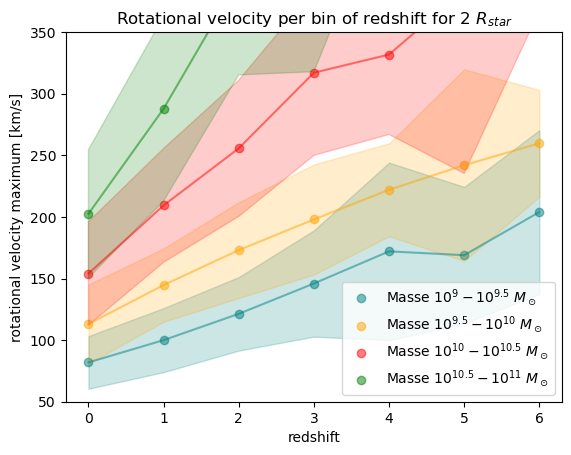

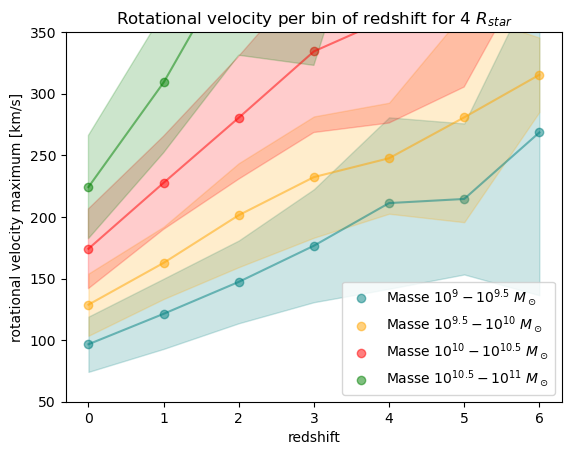

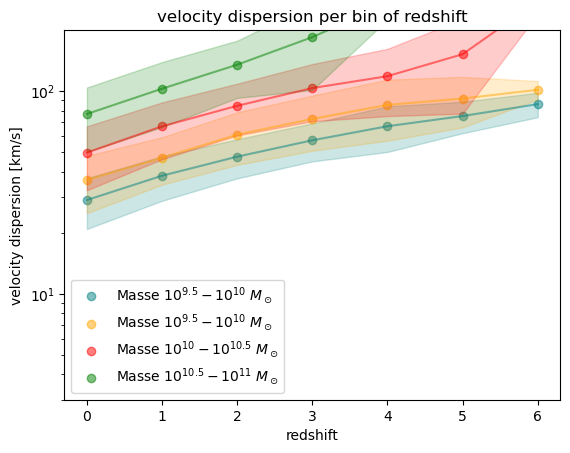

In [70]:
plt.figure(1)
plt.scatter(redshift_list, mean_comp_rot_bin_1, color="teal", alpha=0.5, label=r'Masse $10^{9}-10^{9.5}$ $M_\odot$')
plt.plot(redshift_list, mean_comp_rot_bin_1, color="teal", alpha=0.5)
plt.fill_between(redshift_list, mean_comp_rot_bin_1 - std_comp_rot_bin_1, mean_comp_rot_bin_1 + std_comp_rot_bin_1, color="teal", alpha=0.2)

plt.scatter(redshift_list, mean_comp_rot_bin_2, color="orange", alpha=0.5, label=r'Masse $10^{9.5}-10^{10}$ $M_\odot$')
plt.plot(redshift_list, mean_comp_rot_bin_2, color="orange", alpha=0.5)
plt.fill_between(redshift_list, mean_comp_rot_bin_2 - std_comp_rot_bin_2, mean_comp_rot_bin_2 + std_comp_rot_bin_2, color="orange", alpha=0.2)

plt.scatter(redshift_list, mean_comp_rot_bin_3, color="red", alpha=0.5, label=r'Masse $10^{10}-10^{10.5}$ $M_\odot$')
plt.plot(redshift_list, mean_comp_rot_bin_3, color="red", alpha=0.5)
plt.fill_between(redshift_list, mean_comp_rot_bin_3 - std_comp_rot_bin_3, mean_comp_rot_bin_3 + std_comp_rot_bin_3, color="red", alpha=0.2)

plt.scatter(redshift_list, mean_comp_rot_bin_4, color="green", alpha=0.5, label=r'Masse $10^{10.5}-10^{11}$ $M_\odot$')
plt.plot(redshift_list, mean_comp_rot_bin_4, color="green", alpha=0.5)
plt.fill_between(redshift_list, mean_comp_rot_bin_4 - std_comp_rot_bin_4, mean_comp_rot_bin_4 + std_comp_rot_bin_4, color="green", alpha=0.2)

plt.title(r"Rotational velocity per bin of redshift for 2 $R_{star}$")
plt.xlabel("redshift")
plt.ylabel("rotational velocity maximum [km/s]")
plt.ylim(50,350)
plt.legend()

plt.figure(2)
plt.scatter(redshift_list, mean_rot_bin_1, color="teal", alpha=0.5, label=r'Masse $10^{9}-10^{9.5}$ $M_\odot$')
plt.plot(redshift_list, mean_rot_bin_1, color="teal", alpha=0.5)
plt.fill_between(redshift_list, mean_rot_bin_1 - std_rot_bin_1, mean_rot_bin_1 + std_rot_bin_1, color="teal", alpha=0.2)

plt.scatter(redshift_list, mean_rot_bin_2, color="orange", alpha=0.5, label=r'Masse $10^{9.5}-10^{10}$ $M_\odot$')
plt.plot(redshift_list, mean_rot_bin_2, color="orange", alpha=0.5)
plt.fill_between(redshift_list, mean_rot_bin_2 - std_rot_bin_2, mean_rot_bin_2 + std_rot_bin_2, color="orange", alpha=0.2)

plt.scatter(redshift_list, mean_rot_bin_3, color="red", alpha=0.5, label=r'Masse $10^{10}-10^{10.5}$ $M_\odot$')
plt.plot(redshift_list, mean_rot_bin_3, color="red", alpha=0.5)
plt.fill_between(redshift_list, mean_rot_bin_3 - std_rot_bin_3, mean_rot_bin_3 + std_rot_bin_3, color="red", alpha=0.2)

plt.scatter(redshift_list, mean_rot_bin_4, color="green", alpha=0.5, label=r'Masse $10^{10.5}-10^{11}$ $M_\odot$')
plt.plot(redshift_list, mean_rot_bin_4, color="green", alpha=0.5)
plt.fill_between(redshift_list, mean_rot_bin_4 - std_rot_bin_4, mean_rot_bin_4 + std_rot_bin_4, color="green", alpha=0.2)

plt.title(r"Rotational velocity per bin of redshift for 4 $R_{star}$")
plt.xlabel("redshift")
plt.ylabel("rotational velocity maximum [km/s]")
plt.ylim(50,350)
plt.legend()

plt.figure(3)
plt.scatter(redshift_list, mean_velocity_bin1, color="teal", alpha=0.5, label=r'Masse $10^{9.5}-10^{10}$ $M_\odot$')
plt.plot(redshift_list, mean_velocity_bin1, color="teal", alpha=0.5)
plt.fill_between(redshift_list, mean_velocity_bin1 - std_velocity_bin1, mean_velocity_bin1 + std_velocity_bin1, color="teal", alpha=0.2)

plt.scatter(redshift_list, mean_velocity_bin2, color="orange", alpha=0.5, label=r'Masse $10^{9.5}-10^{10}$ $M_\odot$')
plt.plot(redshift_list, mean_velocity_bin2, color="orange", alpha=0.5)
plt.fill_between(redshift_list, mean_velocity_bin2 - std_velocity_bin2, mean_velocity_bin2 + std_velocity_bin2, color="orange", alpha=0.2)

plt.scatter(redshift_list, mean_velocity_bin3, color="red", alpha=0.5, label=r'Masse $10^{10}-10^{10.5}$ $M_\odot$')
plt.plot(redshift_list, mean_velocity_bin3, color="red", alpha=0.5)
plt.fill_between(redshift_list, mean_velocity_bin3 - std_velocity_bin3, mean_velocity_bin3 + std_velocity_bin3, color="red", alpha=0.2)

plt.scatter(redshift_list, mean_velocity_bin4, color="green", alpha=0.5, label=r'Masse $10^{10.5}-10^{11}$ $M_\odot$')
plt.plot(redshift_list, mean_velocity_bin4, color="green", alpha=0.5)
plt.fill_between(redshift_list, mean_velocity_bin4 - std_velocity_bin4, mean_velocity_bin4 + std_velocity_bin4, color="green", alpha=0.2)

plt.title(r"velocity dispersion per bin of redshift")
plt.xlabel("redshift")
plt.ylabel("velocity dispersion [km/s]")
plt.yscale("log")
plt.ylim(3,10**2.3)

plt.legend()
plt.show()


# One to one comparison with Annalisa 

## Coordinates

In [71]:
# File path
file_path = "/vera/ptmp/gc/apillepi/sims.TNG/L35n2160TNG/appostprocessing/upVectors/Subhalo_upVector_Stars_inRad_099.hdf5"

# Open the HDF5 file
with h5py.File(file_path, 'r') as f:
    # Access and read the datasets
    upvector_minor_axis = f['Subhalo/UpVector_Stars_InRad_minorAxis'][:]
    done = f['Subhalo/Done'][:]

Id = np.arange(0,len(done))

In [72]:
Done = done.astype(bool)

In [73]:
upvector_minor_axis

array([[ 0.06911316,  0.05245344, -0.27788738, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71343031,  0.02756956, -0.68385453, ...,  0.        ,
         0.        ,  0.        ],
       [-0.69730952,  0.99824273, -0.67462699, ...,  0.        ,
         0.        ,  0.        ]])

In [74]:
My_vect = eigenvectors_dict[99]

In [75]:
My_ID = dataset_number[99]

In [76]:
Annalisa_ID = Id[Done]

In [77]:
Annalisa_vect_1 = upvector_minor_axis[0]
Annalisa_vect_2 = upvector_minor_axis[1]
Annalisa_vect_3 = upvector_minor_axis[2]

In [78]:
My_vect1 = [array[0, 2] for array in My_vect]
My_vect2 = [array[1, 2] for array in My_vect]
My_vect3 = [array[2, 2] for array in My_vect]

In [79]:
Annalisa_vect_1_for_comp  = np.array([Annalisa_vect_1[idx] for idx in My_ID])
Annalisa_vect_2_for_comp  = np.array([Annalisa_vect_2[idx] for idx in My_ID])
Annalisa_vect_3_for_comp  = np.array([Annalisa_vect_3[idx] for idx in My_ID])

Done_sel = np.array([Done[idx] for idx in My_ID])

In [80]:
Comp1 =  np.abs(Annalisa_vect_1_for_comp) - np.abs(My_vect1)
Comptocomp1 = Comp1[Done_sel]

Comp2 =  np.abs(Annalisa_vect_2_for_comp) - np.abs(My_vect2)
Comptocomp2 = Comp2[Done_sel]

Comp3 =  np.abs(Annalisa_vect_3_for_comp) - np.abs(My_vect3)
Comptocomp3 = Comp3[Done_sel]

Text(0, 0.5, 'Difference')

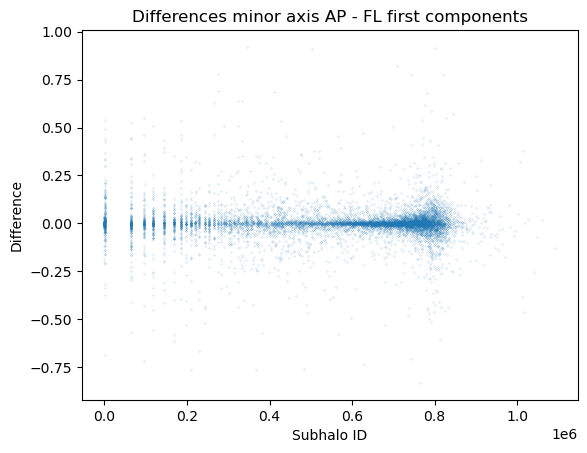

In [81]:
plt.scatter(My_ID,(np.abs(Annalisa_vect_1_for_comp) - np.abs(My_vect1)),s=0.01)
plt.title(r"Differences minor axis AP - FL first components")
plt.xlabel("Subhalo ID")
plt.ylabel("Difference")

Text(0, 0.5, 'Difference')

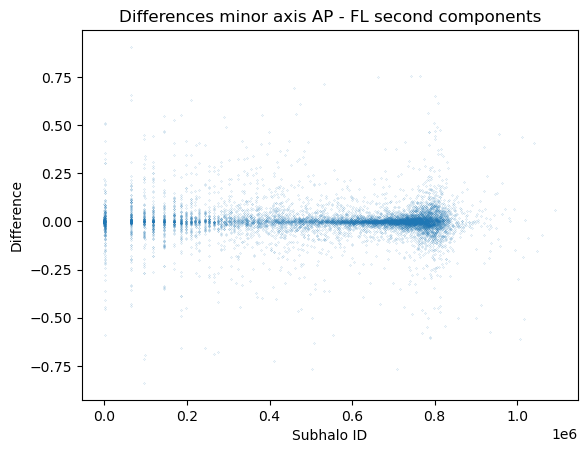

In [82]:
plt.scatter(My_ID,(np.abs(Annalisa_vect_2_for_comp) - np.abs(My_vect2)),s=0.01)
plt.title(r"Differences minor axis AP - FL second components")
plt.xlabel("Subhalo ID")
plt.ylabel("Difference")

Text(0, 0.5, 'Difference')

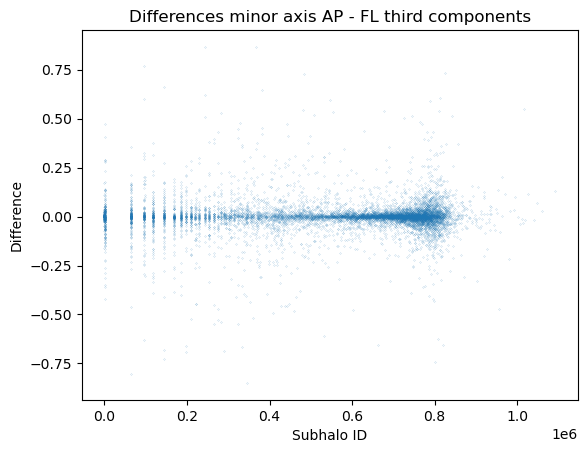

In [83]:
plt.scatter(My_ID,(np.abs(Annalisa_vect_3_for_comp) - np.abs(My_vect3)),s=0.01)
plt.title(r"Differences minor axis AP - FL third components")
plt.xlabel("Subhalo ID")
plt.ylabel("Difference")

## with masses

In [84]:
M_Star_99 = Mass_selec[99]

Text(0, 0.5, 'Difference')

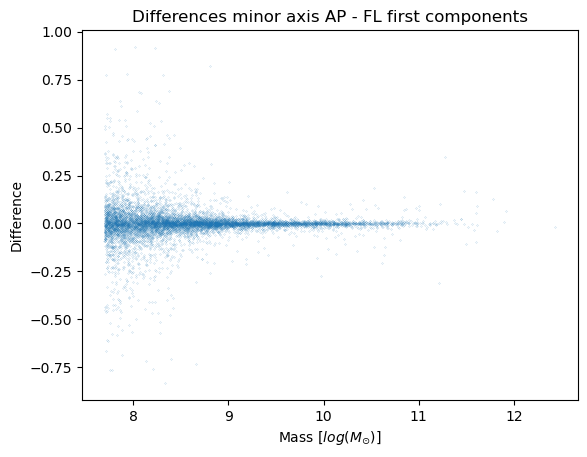

In [85]:
plt.scatter(M_Star_99,(np.abs(Annalisa_vect_1_for_comp) - np.abs(My_vect1)),s=0.01)
plt.title(r"Differences minor axis AP - FL first components")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.ylabel("Difference")

Text(0, 0.5, 'Difference')

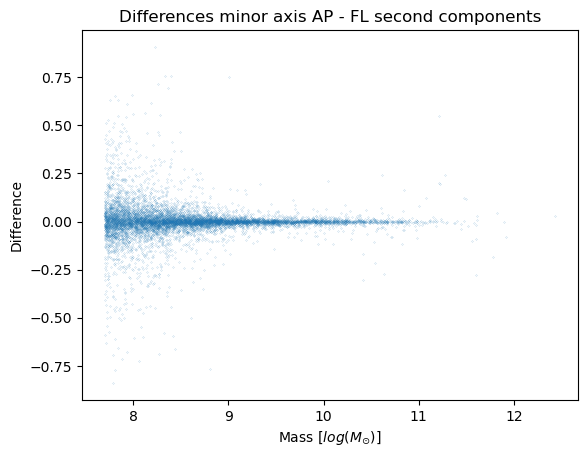

In [86]:
plt.scatter(M_Star_99,(np.abs(Annalisa_vect_2_for_comp) - np.abs(My_vect2)),s=0.01)
plt.title(r"Differences minor axis AP - FL second components")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.ylabel("Difference")

Text(0, 0.5, 'Difference')

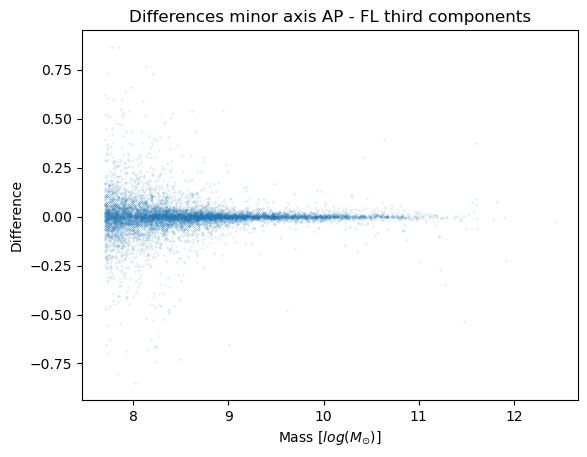

In [87]:
plt.scatter(M_Star_99,(np.abs(Annalisa_vect_3_for_comp) - np.abs(My_vect3)),s=0.01)
plt.title(r"Differences minor axis AP - FL third components")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.ylabel("Difference")

## Kinematics

In [88]:
file_path = "/virgotng/universe/IllustrisTNG/TNG50-1/postprocessing/SlitKinematics/Subhalo_BuserVLum_BinnedSlitKinematics_099.hdf5"

# Open the HDF5 file
with h5py.File(file_path, 'r') as f:
    # Access and read the datasets
    Annalisa_vmax_99 = f['Subhalo/BuserVLum_05ckpc_InRad_V_max_kms'][:]
    Annalisa_vdisp_99 = f['Subhalo/BuserVLum_05ckpc_InRad_sigmaV_binned_HalfRad2Rad'][:]
    done_99 = f['Subhalo/Done'][:]

Id_99 = np.arange(0,len(done_99))
Done_99 = done_99.astype(bool)

My_ID_99 = dataset_number[99]
Annalisa_ID_99 = Id[Done_99]

My_vmax_99 = Vmax_dict[99]
My_comp_vmax_99 = Vmax_comp_dict[99]
My_vdisp_99 = Vdisp_dict[99]

Annalisa_vmax_for_comp_99  = np.array([Annalisa_vmax_99[idx] for idx in My_ID_99])
Annalisa_vdisp_for_comp_99  = np.array([Annalisa_vdisp_99[idx] for idx in My_ID_99])

Done_sel_99 = np.array([Done_99[idx] for idx in My_ID_99])

Comp_99_Vmax = Annalisa_vmax_for_comp_99 - My_vmax_99

Comp_comp_99_Vmax = Annalisa_vmax_for_comp_99 - My_comp_vmax_99

Comp_99_Vdisp = Annalisa_vdisp_for_comp_99 - My_vdisp_99


Text(0, 0.5, 'Difference')

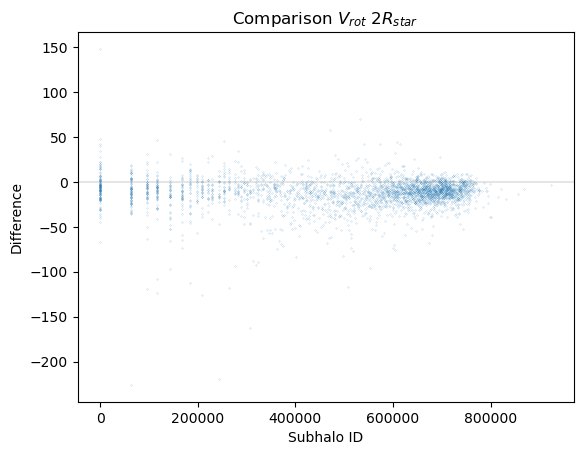

In [89]:
plt.scatter(np.array(My_ID_99)[Done_sel_99],Comp_comp_99_Vmax[Done_sel_99],s=0.01,zorder=0)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{rot}$ $2R_{star}$")
plt.xlabel("Subhalo ID")
plt.ylabel("Difference")

Text(0, 0.5, 'Difference')

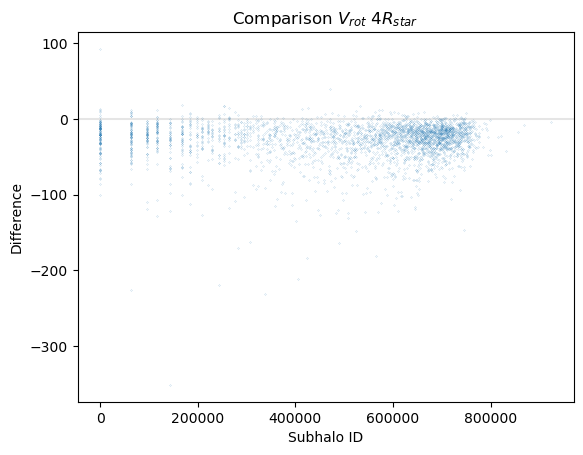

In [90]:
plt.scatter(np.array(My_ID_99)[Done_sel_99],Comp_99_Vmax[Done_sel_99],s=0.01)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{rot}$ $4R_{star}$")
plt.xlabel("Subhalo ID")
plt.ylabel("Difference")

Text(0, 0.5, 'Difference')

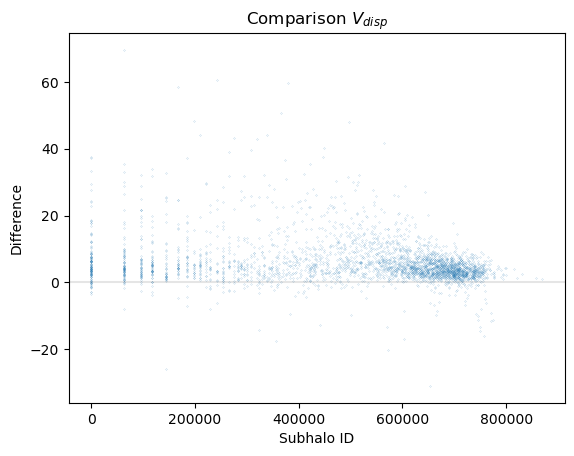

In [91]:
plt.scatter(np.array(My_ID_99)[Done_sel_99],Comp_99_Vdisp[Done_sel_99],s=0.01)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{disp}$")
plt.xlabel("Subhalo ID")
plt.ylabel("Difference")

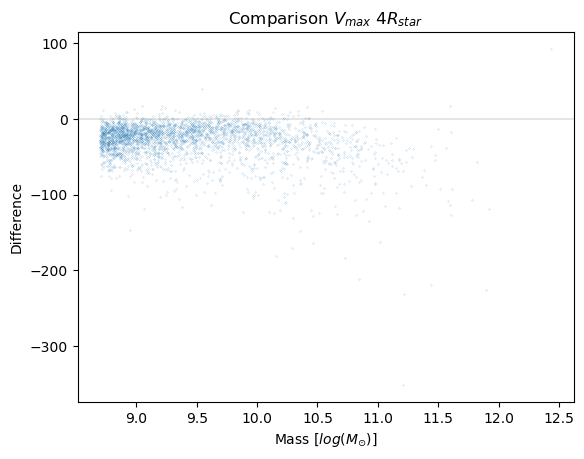

In [92]:
plt.scatter(M_Star_99[Done_sel_99],Comp_99_Vmax[Done_sel_99],s=0.01)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{max}$ $4R_{star}$")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.ylabel("Difference")
plt.show()

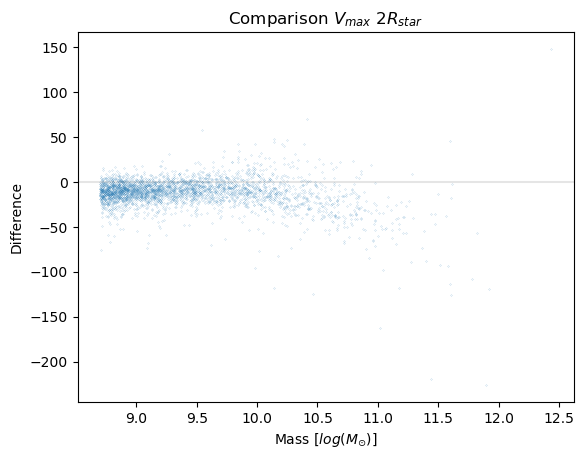

In [93]:
plt.scatter(M_Star_99[Done_sel_99],Comp_comp_99_Vmax[Done_sel_99],s=0.01)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{max}$ $2R_{star}$")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.ylabel("Difference")
plt.show()

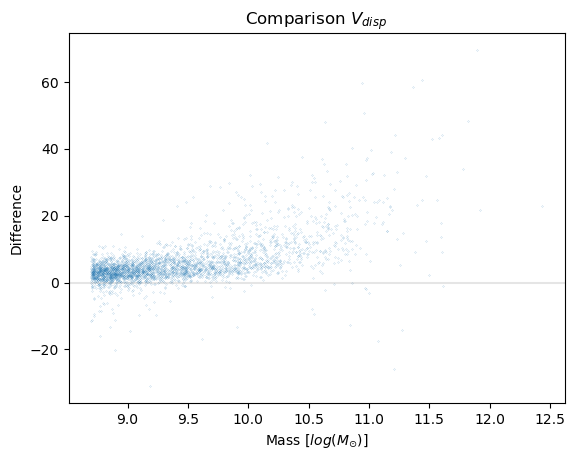

In [94]:
plt.scatter(M_Star_99[Done_sel_99],Comp_99_Vdisp[Done_sel_99],s=0.01)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{disp}$ ")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.ylabel("Difference")
plt.show()

In [95]:
file_path = "/virgotng/universe/IllustrisTNG/TNG50-1/postprocessing/SlitKinematics/Subhalo_BuserVLum_BinnedSlitKinematics_050.hdf5"

# Open the HDF5 file
with h5py.File(file_path, 'r') as f:
    # Access and read the datasets
    Annalisa_vmax_50 = f['Subhalo/BuserVLum_05ckpc_InRad_V_max_kms'][:]
    Annalisa_vdisp_50 = f['Subhalo/BuserVLum_05ckpc_InRad_sigmaV_binned_HalfRad2Rad'][:]
    done_50 = f['Subhalo/Done'][:]

Id_50 = np.arange(0,len(done_50))
Done_50 = done_50.astype(bool)

My_ID_50 = dataset_number[50]
Annalisa_ID_50 = Id_50[Done_50]

My_vmax_50 = Vmax_dict[50]

My_comp_vmax_50 = Vmax_comp_dict[50]

My_vdisp_50 = Vdisp_dict[50]

Annalisa_vmax_for_comp_50  = np.array([Annalisa_vmax_50[idx] for idx in My_ID_50])
Annalisa_vdisp_for_comp_50  = np.array([Annalisa_vdisp_50[idx] for idx in My_ID_50])

Done_sel_50 = np.array([Done_50[idx] for idx in My_ID_50])

Comp_50_Vmax = Annalisa_vmax_for_comp_50 - My_vmax_50


Comp_comp_50_Vmax = Annalisa_vmax_for_comp_50 - My_comp_vmax_50

Comp_50_Vdisp = Annalisa_vdisp_for_comp_50 - My_vdisp_50

M_Star_50 = Mass_selec[50]

Text(0, 0.5, 'Difference')

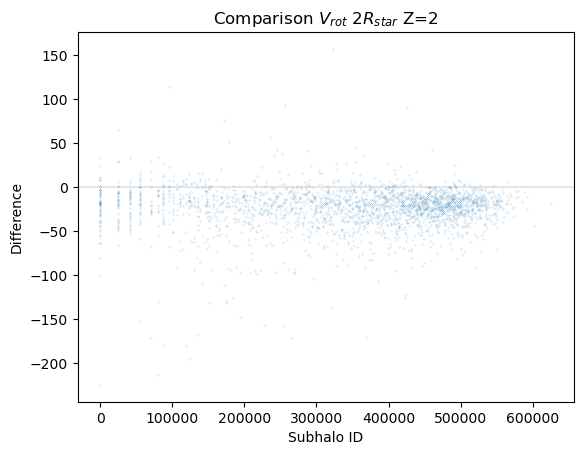

In [96]:
plt.scatter(np.array(My_ID_50)[Done_sel_50],Comp_comp_50_Vmax[Done_sel_50],s=0.01,zorder=0)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{rot}$ $2R_{star}$ Z=2")
plt.xlabel("Subhalo ID")
plt.ylabel("Difference")

Text(0, 0.5, 'Difference')

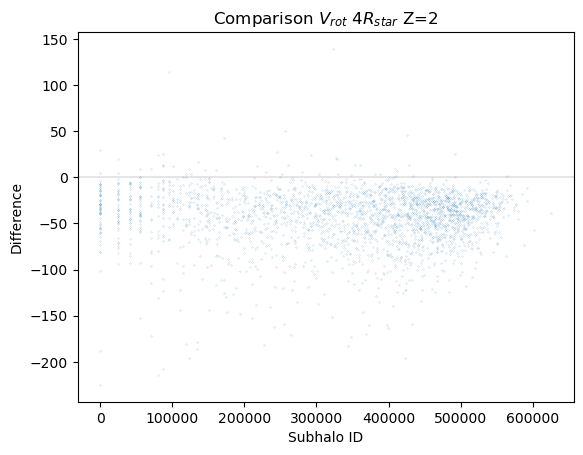

In [97]:
plt.scatter(np.array(My_ID_50)[Done_sel_50],Comp_50_Vmax[Done_sel_50],s=0.01)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{rot}$ $4R_{star}$ Z=2")
plt.xlabel("Subhalo ID")
plt.ylabel("Difference")

Text(0, 0.5, 'Difference')

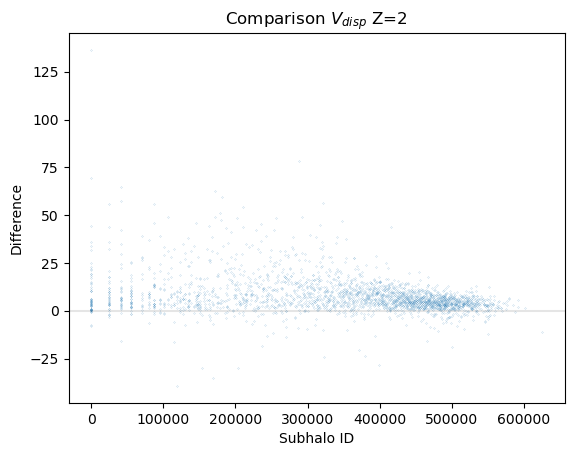

In [98]:
plt.scatter(np.array(My_ID_50)[Done_sel_50],Comp_50_Vdisp[Done_sel_50],s=0.01)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{disp}$ Z=2" )
plt.xlabel("Subhalo ID")
plt.ylabel("Difference")

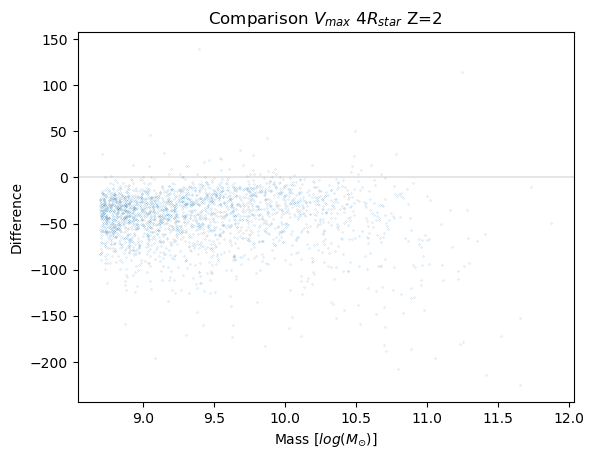

In [99]:
plt.scatter(M_Star_50[Done_sel_50],Comp_50_Vmax[Done_sel_50],s=0.01)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{max}$ $4R_{star}$ Z=2" )
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.ylabel("Difference")
plt.show()

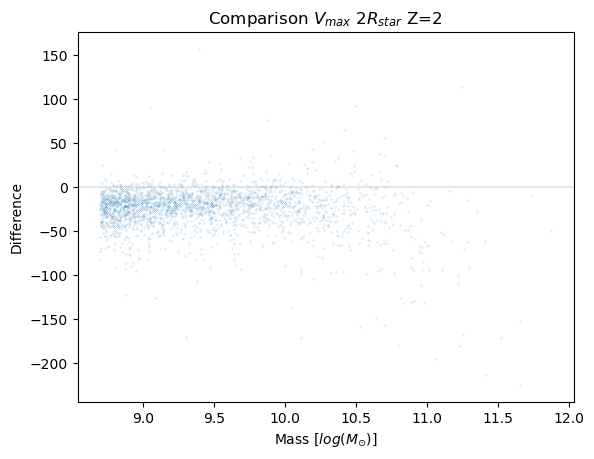

In [100]:
plt.scatter(M_Star_50[Done_sel_50],Comp_comp_50_Vmax[Done_sel_50],s=0.01)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{max}$ $2R_{star}$ Z=2")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.ylabel("Difference")
plt.show()

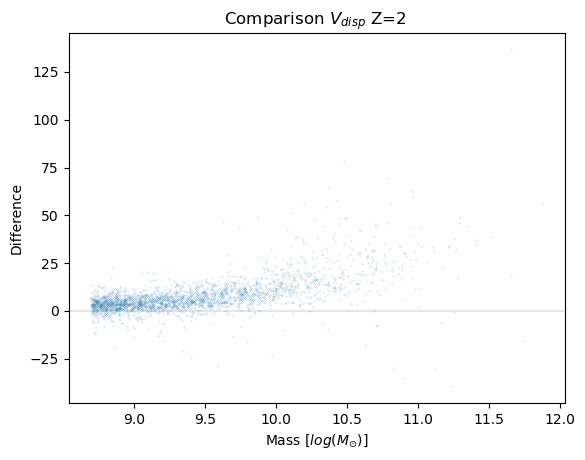

In [101]:
plt.scatter(M_Star_50[Done_sel_50],Comp_50_Vdisp[Done_sel_50],s=0.01)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{disp}$ Z=2 ")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.ylabel("Difference")
plt.show()

In [102]:
file_path = "/virgotng/universe/IllustrisTNG/TNG50-1/postprocessing/SlitKinematics/Subhalo_BuserVLum_BinnedSlitKinematics_033.hdf5"

# Open the HDF5 file
with h5py.File(file_path, 'r') as f:
    # Access and read the datasets
    Annalisa_vmax_33 = f['Subhalo/BuserVLum_05ckpc_InRad_V_max_kms'][:]
    Annalisa_vdisp_33 = f['Subhalo/BuserVLum_05ckpc_InRad_sigmaV_binned_HalfRad2Rad'][:]
    done_33 = f['Subhalo/Done'][:]

Id_33 = np.arange(0,len(done_33))
Done_33 = done_33.astype(bool)

My_ID_33 = dataset_number[33]
Annalisa_ID_33 = Id_33[Done_33]

My_vmax_33 = Vmax_dict[33]

My_comp_vmax_33 = Vmax_comp_dict[33]

My_vdisp_33 = Vdisp_dict[33]

Annalisa_vmax_for_comp_33  = np.array([Annalisa_vmax_33[idx] for idx in My_ID_33])
Annalisa_vdisp_for_comp_33  = np.array([Annalisa_vdisp_33[idx] for idx in My_ID_33])

Done_sel_33 = np.array([Done_33[idx] for idx in My_ID_33])

Comp_33_Vmax = Annalisa_vmax_for_comp_33 - My_vmax_33


Comp_comp_33_Vmax = Annalisa_vmax_for_comp_33 - My_comp_vmax_33

Comp_33_Vdisp = Annalisa_vdisp_for_comp_33 - My_vdisp_33

In [103]:
file_path = "/virgotng/universe/IllustrisTNG/TNG50-1/postprocessing/SlitKinematics/Subhalo_BuserVLum_BinnedSlitKinematics_017.hdf5"

# Open the HDF5 file
with h5py.File(file_path, 'r') as f:
    # Access and read the datasets
    Annalisa_vmax_17 = f['Subhalo/BuserVLum_05ckpc_InRad_V_max_kms'][:]
    Annalisa_vdisp_17 = f['Subhalo/BuserVLum_05ckpc_InRad_sigmaV_binned_HalfRad2Rad'][:]
    done_17 = f['Subhalo/Done'][:]

Id_17 = np.arange(0,len(done_17))
Done_17 = done_17.astype(bool)

My_ID_17 = dataset_number[17]
Annalisa_ID_17 = Id_17[Done_17]

My_vmax_17 = Vmax_dict[17]

My_comp_vmax_17 = Vmax_comp_dict[17]

My_vdisp_17 = Vdisp_dict[17]

Annalisa_vmax_for_comp_17  = np.array([Annalisa_vmax_17[idx] for idx in My_ID_17])
Annalisa_vdisp_for_comp_17  = np.array([Annalisa_vdisp_17[idx] for idx in My_ID_17])

Done_sel_17 = np.array([Done_17[idx] for idx in My_ID_17])

Comp_17_Vmax = Annalisa_vmax_for_comp_17 - My_vmax_17

Comp_comp_17_Vmax = Annalisa_vmax_for_comp_17 - My_comp_vmax_17

Comp_17_Vdisp = Annalisa_vdisp_for_comp_17 - My_vdisp_17

M_Star_17 = Mass_selec[17]

Text(0, 0.5, 'Difference')

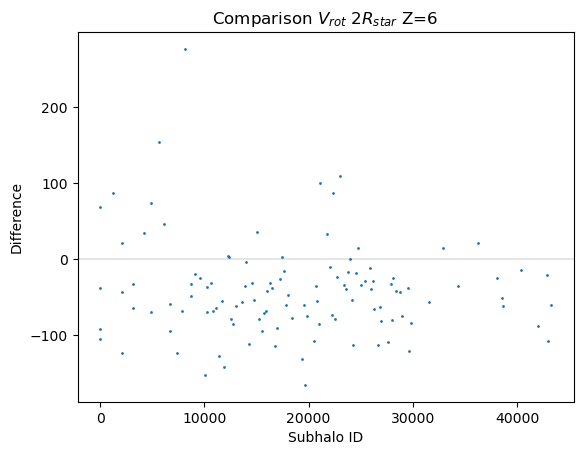

In [124]:
plt.scatter(np.array(My_ID_17)[Done_sel_17],Comp_comp_17_Vmax[Done_sel_17],s=1,zorder=0)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{rot}$ $2R_{star}$ Z=6")
plt.xlabel("Subhalo ID")
plt.ylabel("Difference")

Text(0, 0.5, 'Difference')

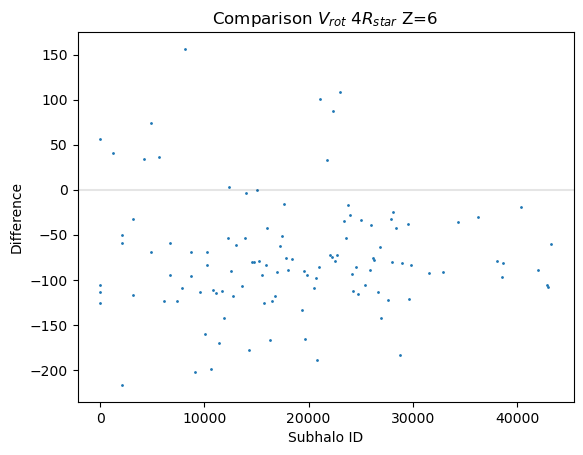

In [125]:
plt.scatter(np.array(My_ID_17)[Done_sel_17],Comp_17_Vmax[Done_sel_17],s=1)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{rot}$ $4R_{star}$ Z=6")
plt.xlabel("Subhalo ID")
plt.ylabel("Difference")

Text(0, 0.5, 'Difference')

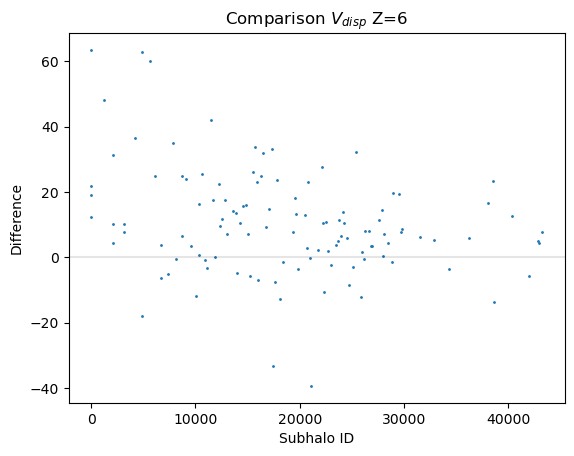

In [126]:
plt.scatter(np.array(My_ID_17)[Done_sel_17],Comp_17_Vdisp[Done_sel_17],s=1)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{disp}$ Z=6" )
plt.xlabel("Subhalo ID")
plt.ylabel("Difference")

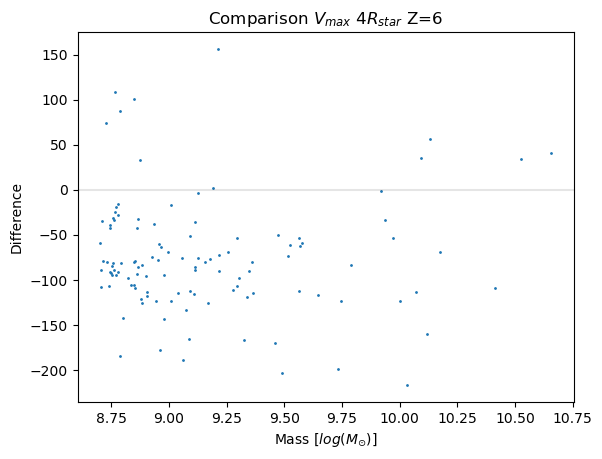

In [127]:
plt.scatter(M_Star_17[Done_sel_17],Comp_17_Vmax[Done_sel_17],s=1)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{max}$ $4R_{star}$ Z=6" )
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.ylabel("Difference")
plt.show()

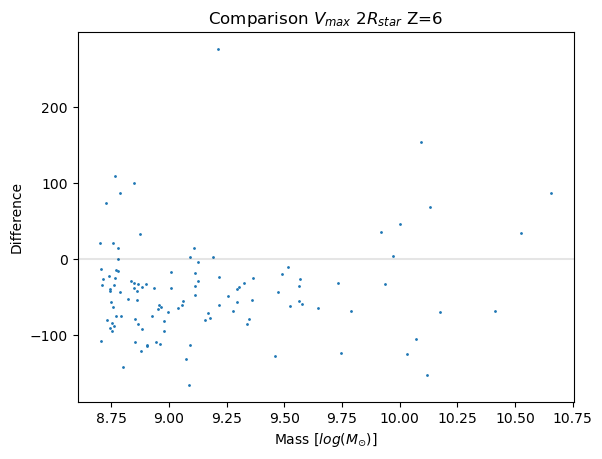

In [128]:
plt.scatter(M_Star_17[Done_sel_17],Comp_comp_17_Vmax[Done_sel_17],s=1)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{max}$ $2R_{star}$ Z=6")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.ylabel("Difference")
plt.show()

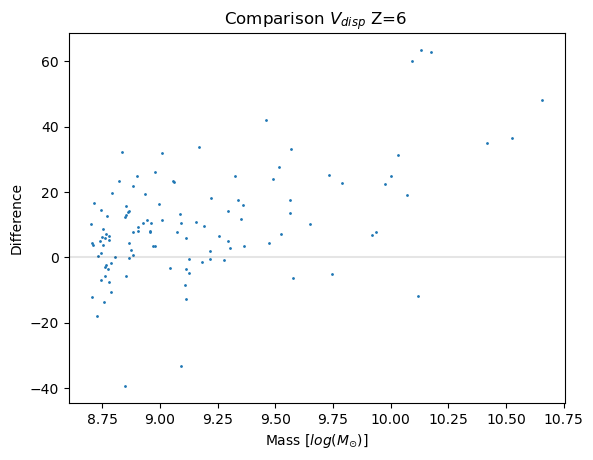

In [129]:
plt.scatter(M_Star_17[Done_sel_17],Comp_17_Vdisp[Done_sel_17],s=1)
plt.axhline(0,color='k',alpha=0.1,zorder=1)
plt.title(r"Comparison $V_{disp}$ Z=6 ")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.ylabel("Difference")
plt.show()

# Plots for Annalisa 

## Z=0

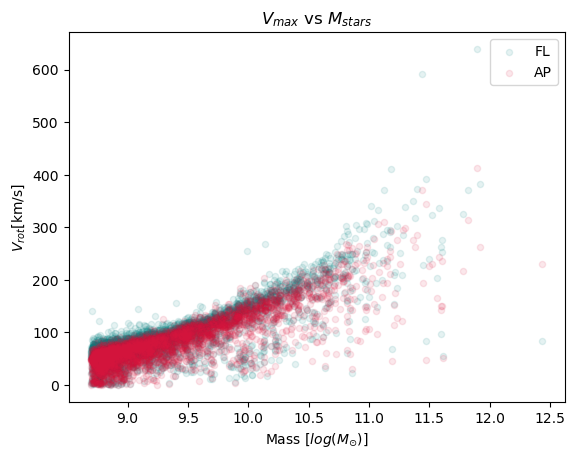

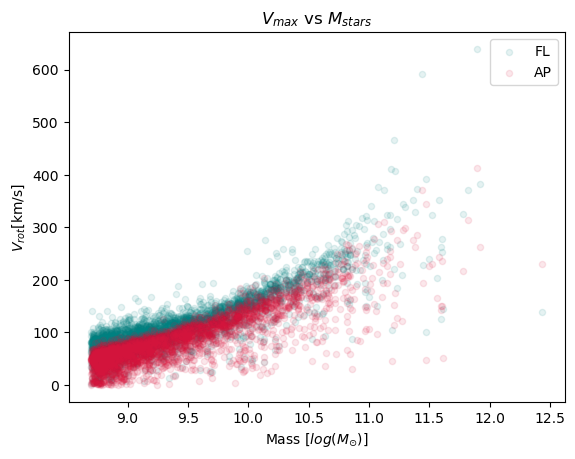

In [110]:
plt.figure(1)
plt.title('$V_{max}$ vs $M_{stars}$')
plt.ylabel(r"$V_{rot}$[km/s]")
plt.xlabel(r"Mass [$log(M_{\odot})$]")

plt.scatter(np.array(M_Star_99)[Done_sel_99],np.array(My_comp_vmax_99)[Done_sel_99],color="teal",marker ="o",alpha = 0.1,s=20,label="FL")
plt.scatter(np.array(M_Star_99)[Done_sel_99],np.array(Annalisa_vmax_for_comp_99)[Done_sel_99],color="crimson",marker ="o",alpha = 0.1,s=20,label="AP")
plt.legend()

plt.figure(2)
plt.title('$V_{max}$ vs $M_{stars}$')
plt.scatter(np.array(M_Star_99)[Done_sel_99],np.array(My_vmax_99)[Done_sel_99],color="teal",marker ="o",alpha = 0.1,s=20,label="FL")
plt.scatter(np.array(M_Star_99)[Done_sel_99],np.array(Annalisa_vmax_for_comp_99)[Done_sel_99],color="crimson",marker ="o",alpha = 0.1,s=20,label="AP")

plt.ylabel(r"$V_{rot}$[km/s]")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.legend()

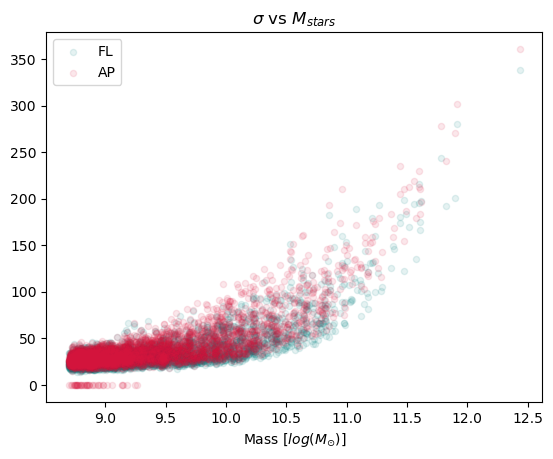

In [111]:
plt.figure()
plt.title(r'$\sigma$ vs $M_{stars}$')
plt.ylabel(r"$V_{disp}$[km/s]")
plt.xlabel(r"Mass [$log(M_{\odot})$]")

plt.ylabel("")
plt.scatter(np.array(M_Star_99)[Done_sel_99],np.array(My_vdisp_99)[Done_sel_99],color="teal",marker ="o",alpha = 0.1,s=20,label="FL")
plt.scatter(np.array(M_Star_99)[Done_sel_99],np.array(Annalisa_vdisp_for_comp_99)[Done_sel_99],color="crimson",marker ="o",alpha = 0.1,s=20,label="AP")
plt.legend()

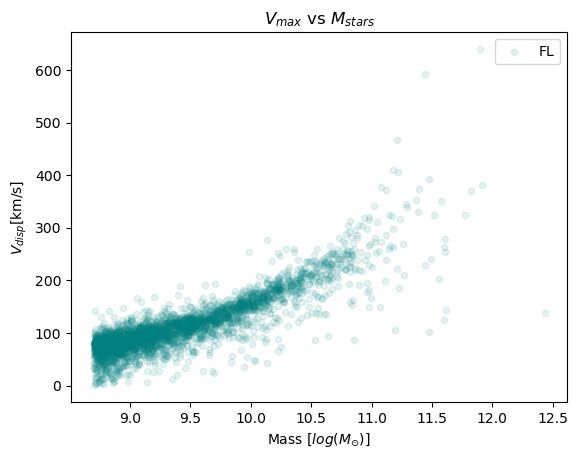

In [112]:
plt.figure()
plt.title(r'$V_{max}$ vs $M_{stars}$')
plt.ylabel(r"$V_{disp}$[km/s]")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.scatter(np.array(M_Star_99)[Done_sel_99],np.array(My_vmax_99)[Done_sel_99],color="teal",marker ="o",alpha = 0.1,s=20,label="FL")
plt.legend()

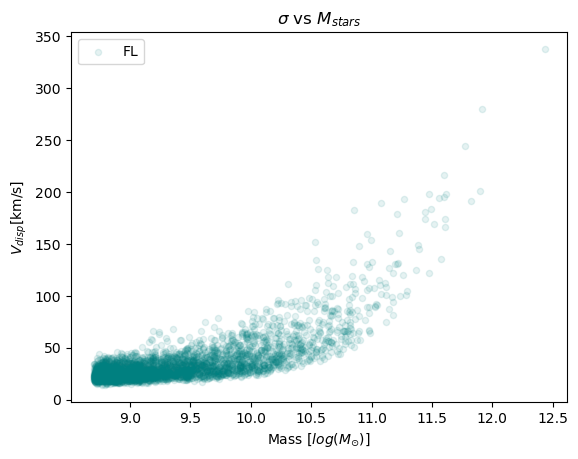

In [113]:
plt.figure()
plt.title(r'$\sigma$ vs $M_{stars}$')
plt.ylabel(r"$V_{disp}$[km/s]")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.scatter(np.array(M_Star_99)[Done_sel_99],np.array(My_vdisp_99)[Done_sel_99],color="teal",marker ="o",alpha = 0.1,s=20,label="FL")
plt.legend()

## Z=2

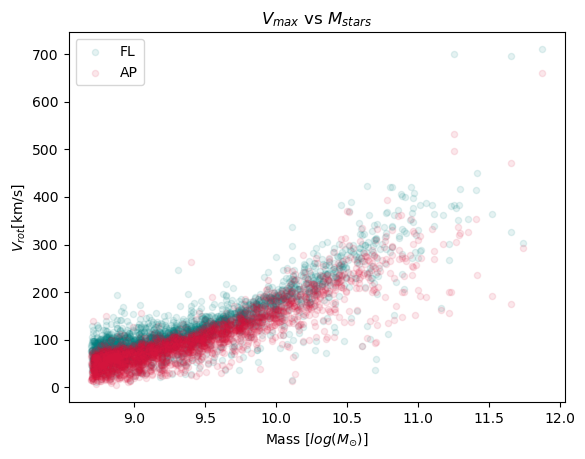

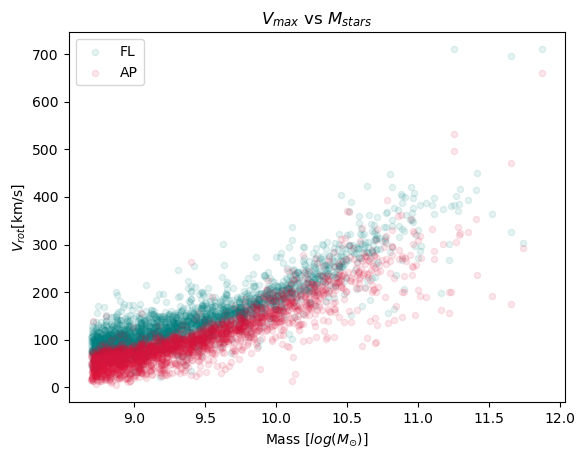

In [114]:
plt.figure(1)
plt.title('$V_{max}$ vs $M_{stars}$')
plt.ylabel(r"$V_{rot}$[km/s]")
plt.xlabel(r"Mass [$log(M_{\odot})$]")

plt.scatter(np.array(M_Star_50)[Done_sel_50],np.array(My_comp_vmax_50)[Done_sel_50],color="teal",marker ="o",alpha = 0.1,s=20,label="FL")
plt.scatter(np.array(M_Star_50)[Done_sel_50],np.array(Annalisa_vmax_for_comp_50)[Done_sel_50],color="crimson",marker ="o",alpha = 0.1,s=20,label="AP")
plt.legend()

plt.figure(2)
plt.title('$V_{max}$ vs $M_{stars}$')
plt.scatter(np.array(M_Star_50)[Done_sel_50],np.array(My_vmax_50)[Done_sel_50],color="teal",marker ="o",alpha = 0.1,s=20,label="FL")
plt.scatter(np.array(M_Star_50)[Done_sel_50],np.array(Annalisa_vmax_for_comp_50)[Done_sel_50],color="crimson",marker ="o",alpha = 0.1,s=20,label="AP")

plt.ylabel(r"$V_{rot}$[km/s]")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.legend()

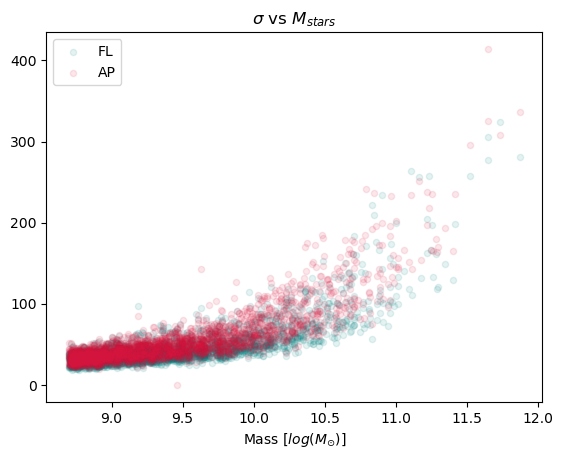

In [115]:
plt.figure()
plt.title(r'$\sigma$ vs $M_{stars}$')
plt.ylabel(r"$V_{disp}$[km/s]")
plt.xlabel(r"Mass [$log(M_{\odot})$]")

plt.ylabel("")
plt.scatter(np.array(M_Star_50)[Done_sel_50],np.array(My_vdisp_50)[Done_sel_50],color="teal",marker ="o",alpha = 0.1,s=20,label="FL")
plt.scatter(np.array(M_Star_50)[Done_sel_50],np.array(Annalisa_vdisp_for_comp_50)[Done_sel_50],color="crimson",marker ="o",alpha = 0.1,s=20,label="AP")
plt.legend()

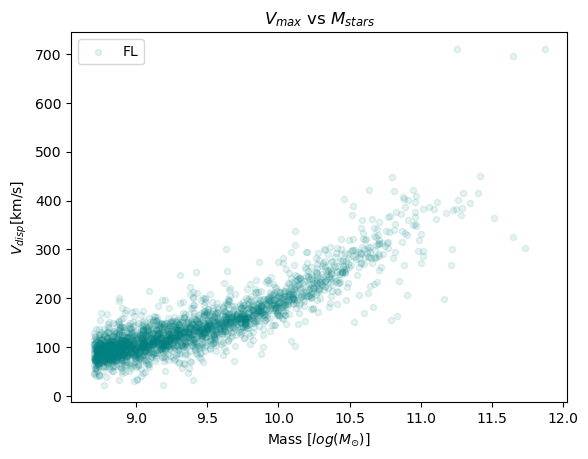

In [116]:
plt.figure()
plt.title(r'$V_{max}$ vs $M_{stars}$')
plt.ylabel(r"$V_{disp}$[km/s]")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.scatter(np.array(M_Star_50)[Done_sel_50],np.array(My_vmax_50)[Done_sel_50],color="teal",marker ="o",alpha = 0.1,s=20,label="FL")
plt.legend()

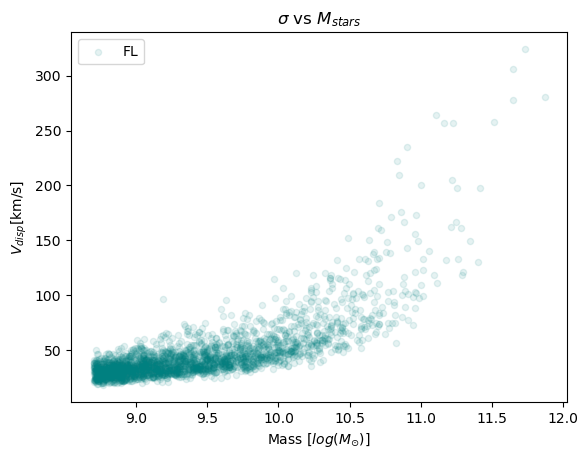

In [117]:
plt.figure()
plt.title(r'$\sigma$ vs $M_{stars}$')
plt.ylabel(r"$V_{disp}$[km/s]")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.scatter(np.array(M_Star_50)[Done_sel_50],np.array(My_vdisp_50)[Done_sel_50],color="teal",marker ="o",alpha = 0.1,s=20,label="FL")
plt.legend()

## Z = 5

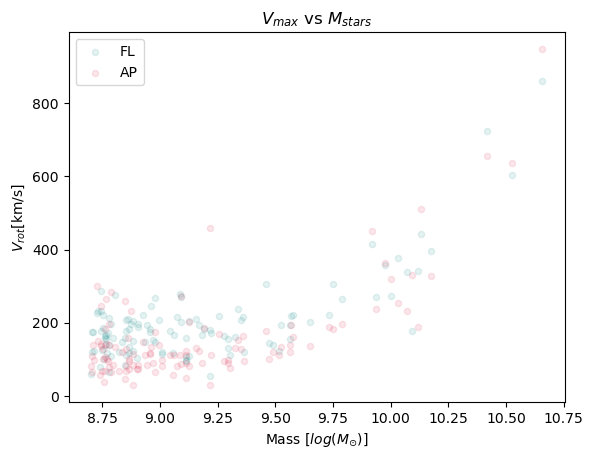

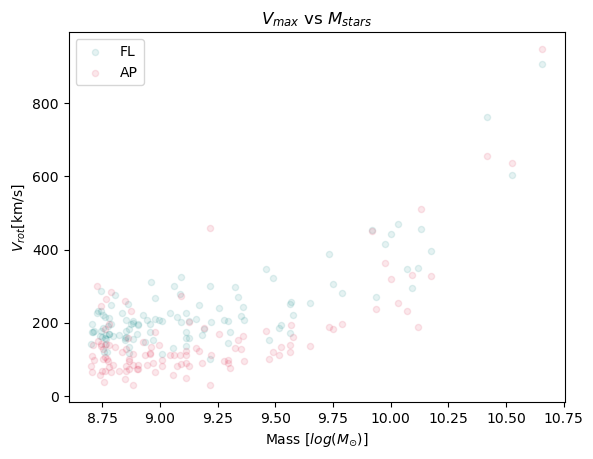

In [118]:
plt.figure(1)
plt.title('$V_{max}$ vs $M_{stars}$')
plt.ylabel(r"$V_{rot}$[km/s]")
plt.xlabel(r"Mass [$log(M_{\odot})$]")

plt.scatter(np.array(M_Star_17)[Done_sel_17],np.array(My_comp_vmax_17)[Done_sel_17],color="teal",marker ="o",alpha = 0.1,s=20,label="FL")
plt.scatter(np.array(M_Star_17)[Done_sel_17],np.array(Annalisa_vmax_for_comp_17)[Done_sel_17],color="crimson",marker ="o",alpha = 0.1,s=20,label="AP")
plt.legend()

plt.figure(2)
plt.title('$V_{max}$ vs $M_{stars}$')
plt.scatter(np.array(M_Star_17)[Done_sel_17],np.array(My_vmax_17)[Done_sel_17],color="teal",marker ="o",alpha = 0.1,s=20,label="FL")
plt.scatter(np.array(M_Star_17)[Done_sel_17],np.array(Annalisa_vmax_for_comp_17)[Done_sel_17],color="crimson",marker ="o",alpha = 0.1,s=20,label="AP")

plt.ylabel(r"$V_{rot}$[km/s]")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.legend()

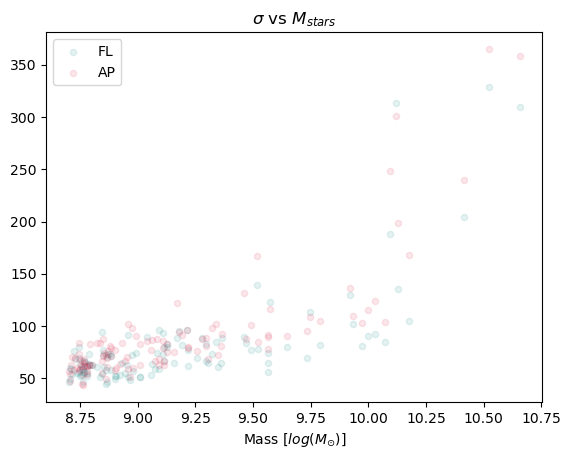

In [119]:
plt.figure()
plt.title(r'$\sigma$ vs $M_{stars}$')
plt.ylabel(r"$V_{disp}$[km/s]")
plt.xlabel(r"Mass [$log(M_{\odot})$]")

plt.ylabel("")
plt.scatter(np.array(M_Star_17)[Done_sel_17],np.array(My_vdisp_17)[Done_sel_17],color="teal",marker ="o",alpha = 0.1,s=20,label="FL")
plt.scatter(np.array(M_Star_17)[Done_sel_17],np.array(Annalisa_vdisp_for_comp_17)[Done_sel_17],color="crimson",marker ="o",alpha = 0.1,s=20,label="AP")
plt.legend()

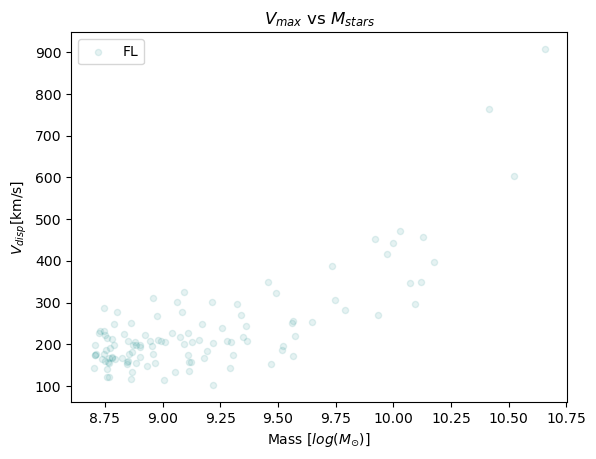

In [120]:
plt.figure()
plt.title(r'$V_{max}$ vs $M_{stars}$')
plt.ylabel(r"$V_{disp}$[km/s]")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.scatter(np.array(M_Star_17)[Done_sel_17],np.array(My_vmax_17)[Done_sel_17],color="teal",marker ="o",alpha = 0.1,s=20,label="FL")
plt.legend()

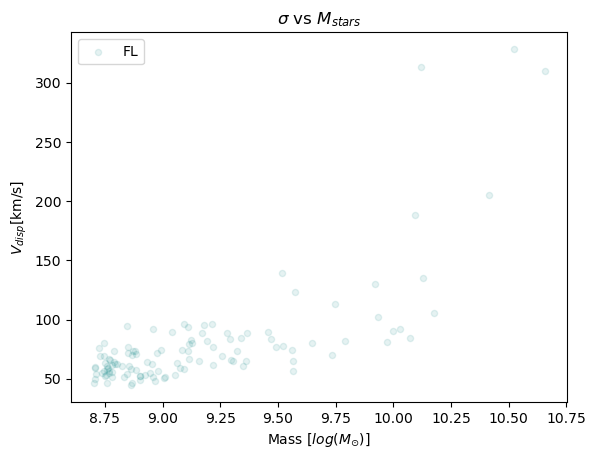

In [121]:
plt.figure()
plt.title(r'$\sigma$ vs $M_{stars}$')
plt.ylabel(r"$V_{disp}$[km/s]")
plt.xlabel(r"Mass [$log(M_{\odot})$]")
plt.scatter(np.array(M_Star_17)[Done_sel_17],np.array(My_vdisp_17)[Done_sel_17],color="teal",marker ="o",alpha = 0.1,s=20,label="FL")
plt.legend()

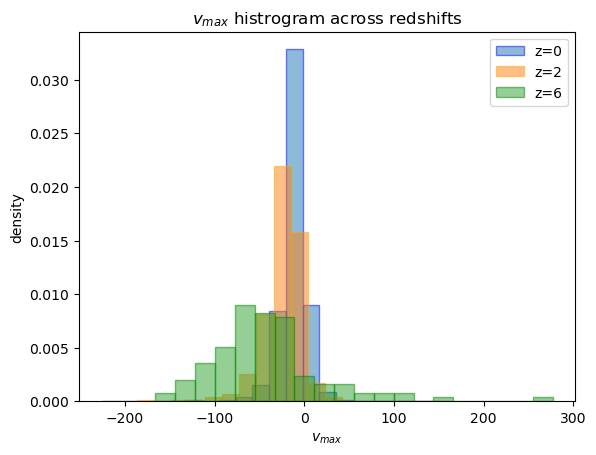

In [122]:
plt.title(r"$v_{max}$ histrogram across redshifts")
plt.xlabel(r"$v_{max}$")
plt.ylabel("density")
plt.hist(Comp_comp_99_Vmax[Done_sel_99],bins=20,density = True,alpha=0.5,edgecolor="blue",label='z=0')
plt.hist(Comp_comp_50_Vmax[Done_sel_50],bins=20,density = True,alpha=0.5,edgecolor="orange",label='z=2')
plt.hist(Comp_comp_17_Vmax[Done_sel_17],bins=20,density = True,alpha=0.5,edgecolor="green",label='z=6')
plt.legend()
plt.show()

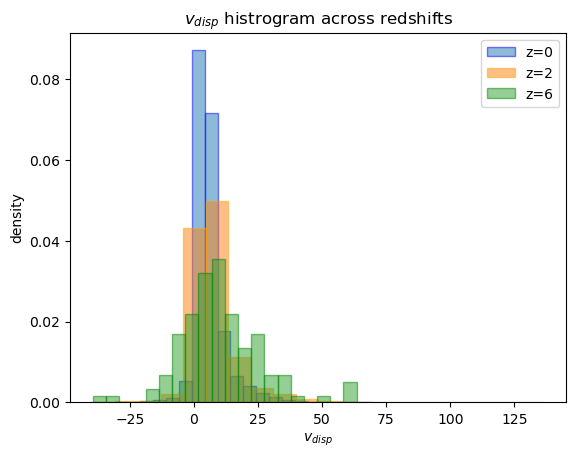

In [123]:
plt.title(r"$v_{disp}$ histrogram across redshifts")
plt.xlabel(r"$v_{disp}$")
plt.ylabel("density")

plt.hist(Comp_99_Vdisp[Done_sel_99],bins=20,density = True,alpha=0.5,edgecolor="blue",label='z=0')
plt.hist(Comp_50_Vdisp[Done_sel_50],bins=20,density = True,alpha=0.5,edgecolor="orange",label='z=2')
plt.hist(Comp_17_Vdisp[Done_sel_17],bins=20,density = True,alpha=0.5,edgecolor="green",label='z=6')
plt.legend()
plt.show()